# RAG

## Vectores e Incrustaciones
### (Vectorstores and Embeddings)

Recordemos todo el proceso para la generacion con respuesta aumentada: (retrieval augmented generation - RAG):

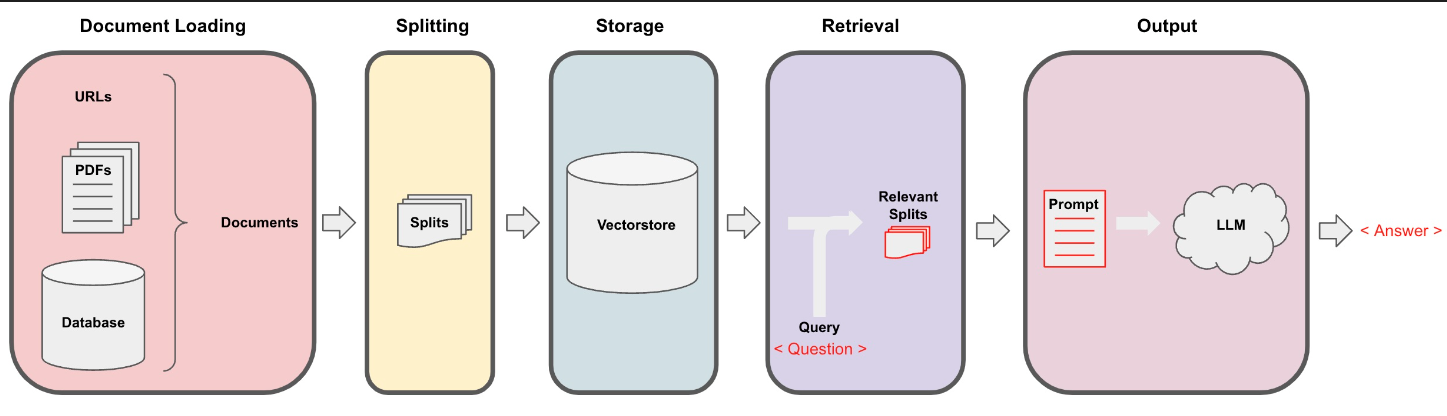

In [ ]:
! pip install -q openai
! pip install -q langchain
! pip install -q panel
! pip install -q jupyter_bokeh
! pip install -q python-dotenv
! pip install -q chromadb
! pip install -q tiktoken
! pip install -q pypdf
! pip install -q chromadb

### Cargamos algunas Variables de Entorno

In [ ]:
import os
import openai
from langchain.chat_models import ChatOpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

### Funcion para cargar los archivos PDF

In [ ]:
from langchain.document_loaders import PyPDFLoader

def load_data():
    # Load PDF
    loaders = [
        PyPDFLoader("docs/politicas-laborales.pdf")
    ]
    docs = []
    for loader in loaders:
        docs.extend(loader.load())
    print(f"Docs: {docs}")
    return docs

### Cortamos el archivo en partes

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def create_splits(docs):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 1500,
        chunk_overlap = 150
    )

    splits = text_splitter.split_documents(docs)
    print(f"Splits Len: {len(splits)}")
    return splits


### Generando Incrustaciones (Embeddings)

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

# persist_directory = 'docs/chroma/'

def get_embeddings():
    # Retorna el generador de embeddings
    embeddings = OpenAIEmbeddings()
    return embeddings

def create_embeddings_and_save(splits):
    embeddings = get_embeddings()

    # remove old database files if any
    # !rm -rf ./docs/chroma/*

    #persistence
    vectordb = Chroma.from_documents(
        documents=splits,
        embedding=embeddings,
        persist_directory=persist_directory
    )
    print(f"Vector Count {vectordb._collection.count()}")
    vectordb.persist()
    return vectordb

In [ ]:
import datetime

def gpt_llm_name():
    current_date = datetime.datetime.now().date()
    if current_date < datetime.date(2023, 9, 2):
        llm_name = "gpt-3.5-turbo-0301"
    else:
        llm_name = "gpt-3.5-turbo"
    print(f"Model {llm_name}")
    return llm_name

In [ ]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end.
 If you don't know the answer, just say that you don't know, don't try to make up an answer.
 Use three sentences maximum.
 Keep the answer as concise as possible.
 Always say "thanks for asking!" at the end of the answer.
{context}
Question: {question}

Chat History: {chat_history}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

# Chat:
 Inicializamos y creamos la cadena de conversacion

In [ ]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

global persist_directory
persist_directory = 'docs/chroma/'

def initialize():
    # Carga de documents
    docs = load_data()

    # Divide los documents que se cargaron
    splits = create_splits(docs)

    # Define las incrustaciones (embedding)
    create_embeddings_and_save(splits)
    # obtiene el generador de incrustaciones
    embeddings = get_embeddings()

    # Crea el vector usando los datos
    vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

    # Define la DB como el retriever para la generacion de la respuesta
    retriever = vectordb.as_retriever()

    # Crea un objeto para guardar el historico
    memory = ConversationBufferMemory(
                    memory_key="chat_history",
                    input_key="question",
                    output_key='answer',
                    return_messages=True
                )

    llm_name = gpt_llm_name()

    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name=llm_name, temperature=0),
        retriever=retriever,
        return_source_documents=True,
        return_generated_question=True,
        memory = memory,
        combine_docs_chain_kwargs={"prompt": QA_CHAIN_PROMPT}
    )
    return qa

In [ ]:
import panel as pn
import param

class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query  = param.String("")
    db_response = param.List([])

    def __init__(self,  **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.loaded_file = "docs/politicas-laborales.pdf"
        # self.qa = load_db(self.loaded_file,"stuff", 4)
        self.qa = initialize()

    def call_load_db(self, count):
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer']
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, styles={'background-color': '#F6F6F6'}))
        ])
        # inp.value = ''  #clears loading indicator when cleared
        return pn.WidgetBox(*self.panels,scroll=True)

    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query )
        )

    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return
        rlist=[pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    @param.depends('convchain', 'clr_history')
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6', 'color': 'black'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self,count=0):
        self.chat_history = []
        print("call clear history")
        return

In [ ]:
cb = cbfs()

In [ ]:
import panel as pn  # GUI
pn.extension(comms='colab')

def collect_messages(_):
    prompt = inp.value_input
    inp.value = ''
    cb.convchain(prompt)
    return pn.WidgetBox(*panels,scroll=True)

panels = cb.panels

inp = pn.widgets.TextInput(value="", placeholder='Enter text here…')
button_conversation = pn.widgets.Button(name="Chat!")

button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)

interactive_conversation = pn.bind(collect_messages, button_conversation)

tab1 = pn.Column(
    pn.Row(inp),
    pn.Row(button_conversation),
    pn.layout.Divider(),
    pn.panel(interactive_conversation, loading_indicator=True, height=500, width = 600, overflow="auto"),
    pn.layout.Divider(),
)

tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4=pn.Column(
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic")),
    pn.layout.Divider()
)

dashboard = pn.panel(
    pn.Column(
    pn.Row(pn.pane.Markdown('# Chat + Politicas')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3), ('Configure', tab4))
), height=700, width = 600, overflow="auto")

dashboard.show() # shows a webpage in localhost